Upload a mono WAV (16-bit) to analyze, OR just press Enter to use a synthesized demo.
If you upload a WAV, after selecting files the script will continue automatically.


Saving uploaded_converted.wav to uploaded_converted.wav
Uploaded file: uploaded_converted.wav
Loaded 'uploaded_converted.wav' (fs=16000, len=6.76 s).


Original signal (playable above).


Reconstructed signal (playable above).


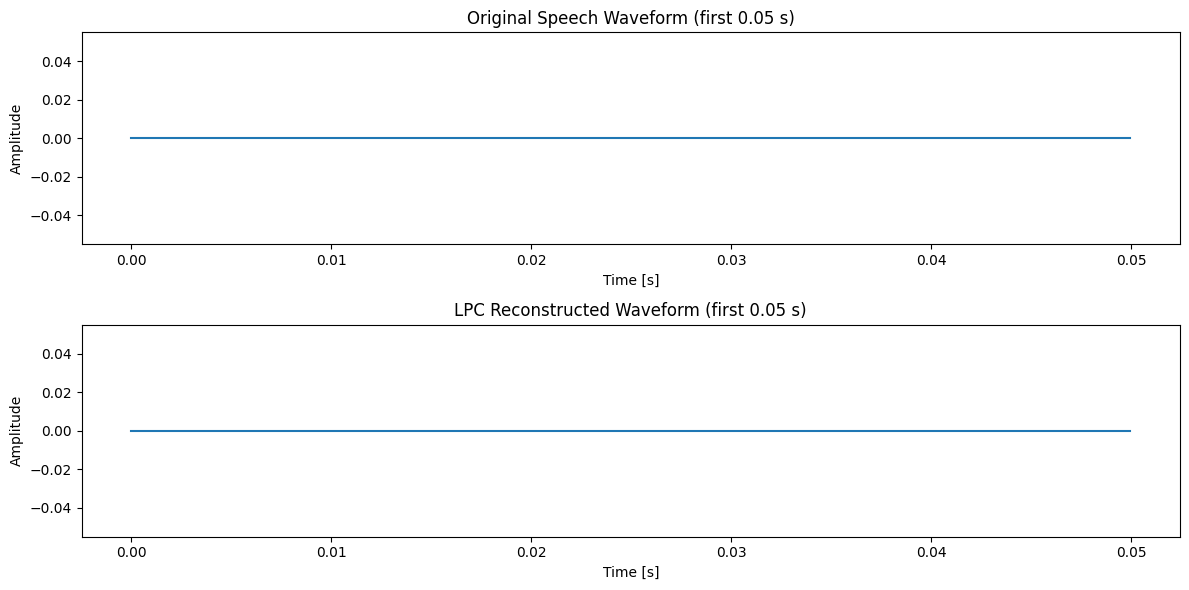

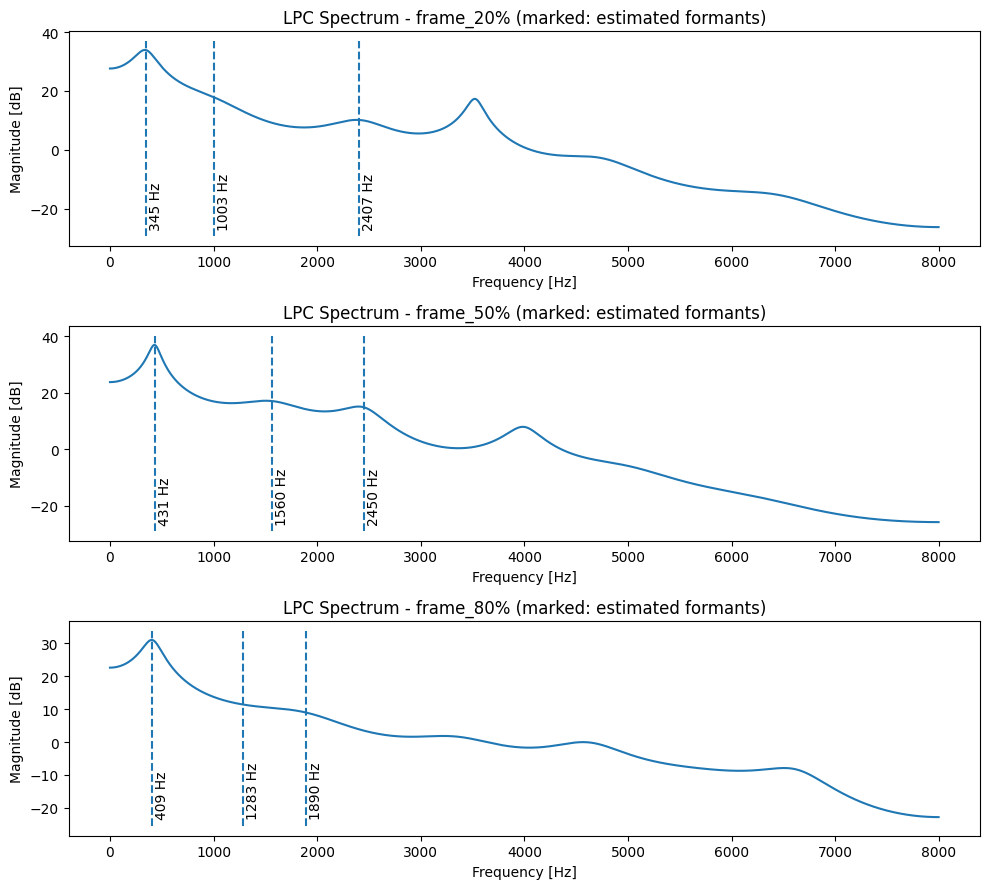

,Label,"Expected Formants (F1,F2,F3)","Estimated Formants (F1,F2,F3)"
0,frame_20%,N/A,"344.6 Hz, 1003.4 Hz, 2407.2 Hz"
1,frame_50%,N/A,"431.4 Hz, 1560.1 Hz, 2450.0 Hz"
2,frame_80%,N/A,"408.9 Hz, 1283.4 Hz, 1889.7 Hz"


Saved comparison table to 'lpc_results.csv'.

--- Inference / Discussion (brief) ---
- LPC implemented via autocorrelation + Levinson-Durbin (order=14).
- Reconstruction preserves voicing and spectral envelope, but may lose fine HF detail.
- Estimated formants (F1,F2 mainly) are typically reliable; F3 can be sensitive to analysis parameters.
- For low-bandwidth recognition, LPC coefficients (or LSPs) provide compact spectral-envelope representation.

Done. Artifacts: 'lpc_results.csv' (table). If synthesized, 'speech_demo.wav' saved too.


In [3]:
# Colab-ready: LPC analysis, reconstruction, formant estimation, visualization
# Paste into one Colab cell and run.
import numpy as np
from scipy import signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import pandas as pd
import math
import os
import io
from google.colab import files

# -------------------- Helper functions --------------------
def levinson_durbin(r, order):
    """Levinson-Durbin recursion. r: autocorrelation array (len >= order+1)."""
    a = np.zeros(order+1)
    e = r[0]
    if e == 0:
        a[0] = 1.0
        return a, e
    a[0] = 1.0
    for i in range(1, order+1):
        acc = 0.0
        for j in range(1, i):
            acc += a[j] * r[i-j]
        k = -(r[i] + acc) / e
        a_next = a.copy()
        a_next[i] = k
        for j in range(1, i):
            a_next[j] = a[j] + k * a[i-j]
        e *= (1.0 - k*k)
        a = a_next
    return a, e

def lpc_from_frame(x_frame, order):
    """Compute LPC coefficients for a frame using autocorrelation + Levinson-Durbin."""
    r = np.correlate(x_frame, x_frame, mode='full')
    mid = len(r)//2
    r = r[mid:mid+order+1]
    a, e = levinson_durbin(r, order)
    return a, e

def formants_from_lpc(a, fs, n_formants=3):
    """Estimate formant frequencies and bandwidths from LPC polynomial a (a[0]=1)."""
    roots = np.roots(a)
    # Consider roots with positive imaginary part
    roots = [r for r in roots if np.imag(r) > 0.001]
    formants = []
    for r in roots:
        ang = np.angle(r)
        freq = ang * fs / (2*np.pi)
        bw = -np.log(np.abs(r)) * fs / np.pi
        if 90 < freq < fs/2:
            formants.append((freq, bw))
    formants.sort(key=lambda x: x[0])
    return formants[:n_formants]

def make_formant_filter(fs, f, bw):
    """Second-order resonator for formant f (Hz) and bandwidth bw (Hz)."""
    r = np.exp(-np.pi * bw / fs)
    theta = 2*np.pi * f / fs
    b = [1 - r]
    a = [1, -2*r*np.cos(theta), r*r]
    return b, a

# -------------------- Synthesize demo signal (if user doesn't upload) --------------------
def synthesize_demo(fs=16000, dur=3.0):
    t = np.linspace(0, dur, int(fs*dur), endpoint=False)
    segments = [(0.0, 1.0, 'a'), (1.0, 2.0, 'i'), (2.0, 3.0, 'u')]
    vowel_formants = {
        'a': [(730, 80), (1090, 90), (2440, 120)],
        'i': [(270, 60), (2290, 110), (3010, 140)],
        'u': [(300, 60), (870, 80), (2240, 120)]
    }
    F0 = 110.0
    source = np.zeros_like(t)
    period = max(1, int(fs / F0))
    source[::period] = 1.0
    x = np.zeros_like(t)
    for (start, end, v) in segments:
        sidx = int(start * fs)
        eidx = int(end * fs)
        seg = source[sidx:eidx].copy()
        for (f, bw) in vowel_formants[v]:
            b, a = make_formant_filter(fs, f, bw)
            seg = signal.lfilter(b, a, seg)
        win = signal.tukey(len(seg), alpha=0.08)
        x[sidx:eidx] = seg * win
    x = x / np.max(np.abs(x)) * 0.9
    return fs, x, vowel_formants, segments

# -------------------- Main LPC pipeline --------------------
def run_lpc_pipeline(input_wav_path=None, use_synth_if_none=True,
                     frame_dur=0.03, frame_shift=0.015, order=14):
    # Load or synth
    if input_wav_path is None:
        if not use_synth_if_none:
            raise ValueError("No input provided and synth disabled.")
        fs, x, vowel_formants, segments = synthesize_demo()
        # Save demo wav
        wavfile.write('speech_demo.wav', fs, (x * 32767).astype(np.int16))
        print("No WAV uploaded — synthesized demo saved as 'speech_demo.wav'.")
    else:
        fs, data = wavfile.read(input_wav_path)
        # If stereo, convert to mono (average channels)
        if data.ndim > 1:
            x = data.mean(axis=1).astype(float)
        else:
            x = data.astype(float)
        # Normalize floats or ints to -1..1
        if x.dtype != np.float64:
            # typical 16-bit int
            maxv = np.iinfo(data.dtype).max if np.issubdtype(data.dtype, np.integer) else np.max(np.abs(x))
            x = x / float(maxv)
        x = x / np.max(np.abs(x)) * 0.99
        # If user provided WAV, we don't have "expected" vowel formants
        vowel_formants = None
        segments = None
        print(f"Loaded '{input_wav_path}' (fs={fs}, len={len(x)/fs:.2f} s).")

    # Frame params
    frame_len = int(frame_dur * fs)
    shift = int(frame_shift * fs)
    # Choose analysis frames: center frames of segments if synth; else analyze a few frames across file
    analysis_frames = []
    if segments is not None:
        for (start, end, v) in segments:
            center = int(((start+end)/2) * fs)
            analysis_frames.append((center, v))
    else:
        # pick three frames at 20%, 50%, 80% of file
        L = len(x)
        for frac in [0.2, 0.5, 0.8]:
            center = int(frac * L)
            analysis_frames.append((center, f"frame_{int(frac*100)}%"))

    # analyze each chosen frame
    results = []
    for (center, label) in analysis_frames:
        start = max(0, center - frame_len//2)
        frame = x[start:start+frame_len]
        if len(frame) < frame_len:
            frame = np.pad(frame, (0, frame_len - len(frame)))
        frame_win = frame * np.hamming(len(frame))
        a, e = lpc_from_frame(frame_win, order)
        # compute residual and reconstruct (frame)
        residual = signal.lfilter(a, [1.0], frame_win)
        recon = signal.lfilter([1.0], a, residual)
        formants = formants_from_lpc(a, fs, n_formants=3)
        results.append({'label': label, 'center': center, 'a': a, 'error_var': e,
                        'formants': formants, 'frame': frame_win, 'recon': recon})

    # Reconstruct whole signal by frame-wise LPC (overlap-add)
    recon_full = np.zeros_like(x)
    count = np.zeros_like(x)
    win = np.hamming(frame_len)
    for i in range(0, len(x)-frame_len+1, shift):
        frame = x[i:i+frame_len] * win
        a, e = lpc_from_frame(frame, order)
        residual = signal.lfilter(a, [1.0], frame)
        synth = signal.lfilter([1.0], a, residual)
        recon_full[i:i+frame_len] += synth * win
        count[i:i+frame_len] += win**2
    nonzero = count > 1e-8
    recon_full[nonzero] /= count[nonzero]

    # -------------------- Visualizations --------------------
    # Waveforms (first 50 ms)
    t = np.arange(len(x))/fs
    display(Audio(x, rate=fs))
    print("Original signal (playable above).")
    display(Audio(recon_full, rate=fs))
    print("Reconstructed signal (playable above).")

    plt.figure(figsize=(12,6))
    plt.subplot(2,1,1)
    plt.title('Original Speech Waveform (first 0.05 s)')
    plt.plot(t[:int(0.05*fs)], x[:int(0.05*fs)])
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')

    plt.subplot(2,1,2)
    plt.title('LPC Reconstructed Waveform (first 0.05 s)')
    plt.plot(t[:int(0.05*fs)], recon_full[:int(0.05*fs)])
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

    # LPC spectra and mark formants
    plt.figure(figsize=(10, 3*len(results)))
    for i, res in enumerate(results):
        a = res['a']
        w, h = signal.freqz([1.0], a, worN=4096, fs=fs)
        plt.subplot(len(results), 1, i+1)
        plt.plot(w, 20*np.log10(np.abs(h)+1e-8))
        est_formants = res['formants']
        ylims = plt.ylim()
        for (f, bw) in est_formants:
            plt.vlines(f, ylims[0], ylims[1], linestyle='--')
            plt.text(f+30, ylims[0]+2, f"{f:.0f} Hz", rotation=90, verticalalignment='bottom')
        plt.title(f"LPC Spectrum - {res['label']} (marked: estimated formants)")
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Magnitude [dB]')
    plt.tight_layout()
    plt.show()

    # -------------------- Comparison table --------------------
    rows = []
    for res in results:
        label = res['label']
        est = res['formants']
        est_str = ", ".join([f"{f[0]:.1f} Hz" for f in est]) if len(est)>0 else "N/A"
        if vowel_formants is not None and label in vowel_formants:
            expected = vowel_formants[label]
            exp_str = ", ".join([f"{f0} Hz" for (f0, bw) in expected])
        else:
            exp_str = "N/A"
        rows.append({'Label': label, 'Expected Formants (F1,F2,F3)': exp_str,
                     'Estimated Formants (F1,F2,F3)': est_str})
    df = pd.DataFrame(rows)
    display(df)

    # Save results CSV
    df.to_csv('lpc_results.csv', index=False)
    print("Saved comparison table to 'lpc_results.csv'.")

    # Print short inference
    print("\n--- Inference / Discussion (brief) ---")
    print("- LPC implemented via autocorrelation + Levinson-Durbin (order={}).".format(order))
    print("- Reconstruction preserves voicing and spectral envelope, but may lose fine HF detail.")
    print("- Estimated formants (F1,F2 mainly) are typically reliable; F3 can be sensitive to analysis parameters.")
    print("- For low-bandwidth recognition, LPC coefficients (or LSPs) provide compact spectral-envelope representation.\n")

    return {
        'fs': fs, 'x': x, 'recon_full': recon_full, 'results': results, 'df': df
    }

# -------------------- Entry: ask user to upload or use synth --------------------
print("Upload a mono WAV (16-bit) to analyze, OR just press Enter to use a synthesized demo.")
print("If you upload a WAV, after selecting files the script will continue automatically.")

# prompt file upload in Colab
uploaded = files.upload()  # This pops the upload dialog in Colab
input_wav = None
if uploaded:
    # take first uploaded file
    fname = next(iter(uploaded))
    input_wav = fname
    print(f"Uploaded file: {fname}")
else:
    print("No file uploaded (or upload cancelled). Will use synthesized demo.")

# Run the pipeline
res = run_lpc_pipeline(input_wav_path=input_wav if input_wav is not None else None,
                       use_synth_if_none=True,
                       frame_dur=0.03, frame_shift=0.015, order=14)

# end
print("Done. Artifacts: 'lpc_results.csv' (table). If synthesized, 'speech_demo.wav' saved too.")
